# Analiza projektów kickstarter

## Cel projektu

Celem projektu jest przeprowadzenie analizy danych w celu stworzenia i porównania różnych klasyfikatorów. Zadaniem klasyfikatorów będzie określenie na podstawie danych wejściowych czy projekt się powiedzie, czy nie.

## Opis danych

Dane będące przedmiotem analizy niniejszego projektu pochodzą z repozytorium kaggle [kaggle.com/kemical/kickstarter-projects](www.kaggle.com/kemical/kickstarter-projects) i reprezentuja zbiór projektów z serwisu kickstarter.

Zbiór cechuje się następującymi kolumnami:
- ID --- identyfikator w serwisie kickstarter,
- name --- nazwa projektu,
- category --- podkategoria,
- main_category --- główna kategoria,
- currency --- waluta, w której przeprowadza się zbiórkę,
- goal --- kwota docelowa,
- launched --- data uruchomienia zbiórki,
- deadline --- data zakończenia zbiórki,
- pledged --- kwota zebrana przez wspierających,
- state --- aktualny status projektu,
- backers --- ilość osób wspierających,
- country --- kraj, z którego wywodził się projekt,
- usd_pledged --- zebrana kwota przedstawiona w USD.

## Przygotowanie bibliotek wykorzystywanych w systemie

W systemie wykorzystywane są następujące biblioteki:
- **pandas** --- odczyt, zapis i operacje na danych,
- **datetime** --- operacje na datach,
- **sklearn** --- funkcje wykorzystywane w analizie danych,
- **math**, **numpy** --- liczne funkcje matematyczne,
- **seaborn** --- graficzna reprezentacja danych,
- **random** --- generowanie liczb losowych,
- **matplotlib** --- wykresy,
- **scipy** --- metody statystyczne.

In [229]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import math
import numpy as np
import seaborn as sns
import random as rand
import matplotlib.pyplot as plt

## Konfiguracja systemu

Poniższa sekcja zawiera ustawienia dla poszczególnych bibliotek. Są to konfiguracje sposobu wyświetlania danych dla DataFrame oraz kodowania używanego przy wczytywaniu danych z pliku.

In [152]:
# Skonfigurowanie opcji wyświetlania
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

default_figsize = (13, 9)
plt.rcParams["figure.figsize"] = default_figsize

# Parametry wykorzystywane przy wczytywaniu danych
encoding='ISO-8859-1'

## Przygotowanie danych

Na początku należało dokonać wstępnej selekcji kolumn. Wyboru dokonano na podstawie posiadanej wiedzy oraz własnych przekonań co do użyteczności danej kolumny w dalszej analizie. Tym sposobem odrzucono następujące kolumny:
- ID --- identyfikator jest jedynie informacją pozwalającą na operowanie na danych w pewnym systemie. Można by rozważać taki scenariusz, w którym identyfikator świadczy o tym, kiedy projekt został utworzony, jednak do tego może posłużyć bardziej odpowiednia kolumna **launched**,
- category --- ponieważ ta kolumna była szczegółową daną tekstową, prawdopodobnie niewiele znaczyłaby dla algorytmów ją przetwarzających. Aby uzyskać wymierne korzyści z wykorzystania tej kolumny, należałoby skorzystać z przetwarzania języka naturalnego.
- usd_pledged --- konwersja do wspólnej waluty byłaby mile widziana, jednak ta kolumna dotyczyła tylko kwoty zebranej, a nie kwoty docelowej.

### Wczytanie danych

In [153]:
dataset_path = './data/kickstarter-projects-filtered.csv'
rows_number = 1000
all_csv_columns = ['main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country']
df = pd.read_csv(
    dataset_path,
    encoding=encoding,
    low_memory=False
    ).head(rows_number)\
    .filter(all_csv_columns, axis=1)

print(df.head())

  main_category currency        deadline     goal        launched  pledged       state  backers country
0    Publishing      GBP  09-10-15 11:36   1000.0  11-08-15 12:12      0.0      failed        0      GB
1  Film & Video      USD   26-02-13 0:20  45000.0   12-01-13 0:20    220.0      failed        3      US
2         Music      USD   16-04-12 4:24   5000.0   17-03-12 3:24      1.0      failed        1      US
3          Food      USD  01-04-16 13:38  50000.0  26-02-16 13:38  52375.0  successful      224      US
4          Food      USD  21-12-14 18:30   1000.0  01-12-14 18:30   1205.0  successful       16      US


### Konwersja danych tekstowych na dane liczbowe

Aby dane mogły zostać poprawnie przetworzone w dalszych krokach, dane tekstowe należy zamienić na dane liczbowe. Do tego celu można wykorzystać słowniki. Algorytm konwersji jest następujący:
- zebrać wszystkie wartości występujące w danej kolumnie
- przyporządkować każdej wartości kolejną liczbę naturalną rozpoczynając od zera (lub jedynki).

In [154]:
def get_all_values_from_column(df, col_name):
    values = []
    for i in df[col_name].index:
        category = df[col_name][i]
        if category not in values:
            values.append(category)

    return values


def create_label_number_dict(names, start_from_zero = True):
    normalized = {}
    zero_margin = 1 - int(start_from_zero)
    for i in range(0, len(names)):
        name = names[i]
        normalized[name] = i + zero_margin

    return normalized

def map_text_to_number(df, column_name, dict):
    mapped = pd.Series(df[column_name].map(dict), name=column_name)
    df.update(mapped)

    return df

In [155]:
categories = get_all_values_from_column(df, 'main_category')
countries = get_all_values_from_column(df, 'country')
states = get_all_values_from_column(df, 'state')
currencies = get_all_values_from_column(df, 'currency')

categories_dict = create_label_number_dict(categories)
countries_dict = create_label_number_dict(countries)
states_dict = { 'failed': 0, 'successful': 1 }
currencies_dict = create_label_number_dict(currencies)

df = map_text_to_number(df, 'main_category', categories_dict)
df = map_text_to_number(df, 'country', countries_dict)
df = map_text_to_number(df, 'state', states_dict)
df = map_text_to_number(df, 'currency', currencies_dict)

### Konwersja dat na dane liczbowe

W przypadku dat, dla uproszczenia przyjęto strategię reprezentacji ich jako roku.

In [156]:
def date_to_timestamp(dt):
    return datetime.strptime(dt, "%d-%m-%y %H:%M").year


def map_date_to_timestamp(df, column_names):
    for column_name in column_names:
        mapped = pd.Series(df[column_name].map(date_to_timestamp), name=column_name)
        df.update(mapped)

    return df

df = map_date_to_timestamp(df, ['launched', 'deadline'])

### Normalizacja i usuwanie wartości ekstremalnych

W analizie danych jest idealnie, kiedy dane mają rozkład normalny. Niestety dane skrajnie odbiegające od pozostałych powodują, że taka analiza jest dużo cięższa niż w przypadku spójnych danych. To samo dotyczy danych niepełnych, tj. takich, których nie wszystkie kolumny mają wartości. Takich danych należy się pozbyć lub zamienić je wartościami średnimi.

W przypadku wartości skrajnych są one usuwane. Krok ten został dodany w następstwie problemów wynikających z wyżej opisanego zjawiska. Taki stan rzeczy na etapie szukania przedziałów dla reguł rozmytych nie pozwalał na dalszą analizę. Po wprowadzeniu zmian w zbiorze danych, wcześniejsze problemy zostały zażegnane.

In [157]:
x = df
quantile = QuantileTransformer()
X = quantile.fit_transform(x)
df = quantile.transform(X)
df = pd.DataFrame(X)
df.columns = all_csv_columns
df.head()

C:\Users\Hubert\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


,main_category,currency,deadline,goal,launched,pledged,state,backers,country
0,0.000000,0.000000,0.735235,0.169670,0.746747,0.000000,0.0,0.000000,0.000000
1,0.186186,0.508509,0.329830,0.905405,0.337337,0.360360,0.0,0.278278,0.508509
2,0.361862,0.508509,0.176677,0.514014,0.184184,0.139139,0.0,0.165165,0.508509
3,0.471972,0.508509,1.000000,0.918418,1.000000,0.970971,1.0,0.916917,0.508509
4,0.471972,0.508509,0.522022,0.169670,0.529530,0.549049,1.0,0.483483,0.508509


Dla poprawności dalszych kroków można sprawdzić, czy któreś kolumny nie zawierają niepoprawnych/pustych danych.

In [158]:
is_any_nan = False
for column in all_csv_columns:
    is_any_nan = is_any_nan or df[column].isnull().values.any()

print(f'\nCzy istnieją nieprawidłowe wartości w zbiorze danych: {is_any_nan}\n')


Czy istnieją nieprawidłowe wartości w zbiorze danych: False



### Podział zbioru na dane uczące i dane testowe

Do stworzenia systemu potrzebne są zarówno dane uczące --- te, z których algorytmy będą czerpały informacje o zależnościach, jak i dane testowe, wykorzystywane do sprawdzenia poprawności zaimplementowanych algorytmów. Podziału dokonano w stosunku 90/10

In [159]:
train_to_test_ratio = 0.1
df_train, df_test = train_test_split(df, test_size=train_to_test_ratio)

## Analiza PCA

### Wybór ilości kolumn

Analiza PCA pozwala oszacować jaką skuteczność będzie miał system dla danej ilości kolumn. Takie oszacowanie może być bardzo pomocne w wyborze optymalnej ilości kolumn. Jeżeli na podstawie posiadanych danych jesteśmy w stanie stworzyć system, który będzie cechował się skutecznością na poziomie 90% już dla 3 kolumn, to być może jest to wartość wystarczająca, zakładając, że na przykład dla 8 kolumn system będzie miał 93% skuteczności. Wtedy należy rozważyć, czy dodatkowa złożoność wynikająca z uwzględnienia większej ilości kolumn jest warta uzyskania dodatkowych 3 punktów procentowych skuteczności.

Do analizy PCA należy wybrać kolumny reprezentujące cechy danego zbioru, oraz kolumne decyzyjną.

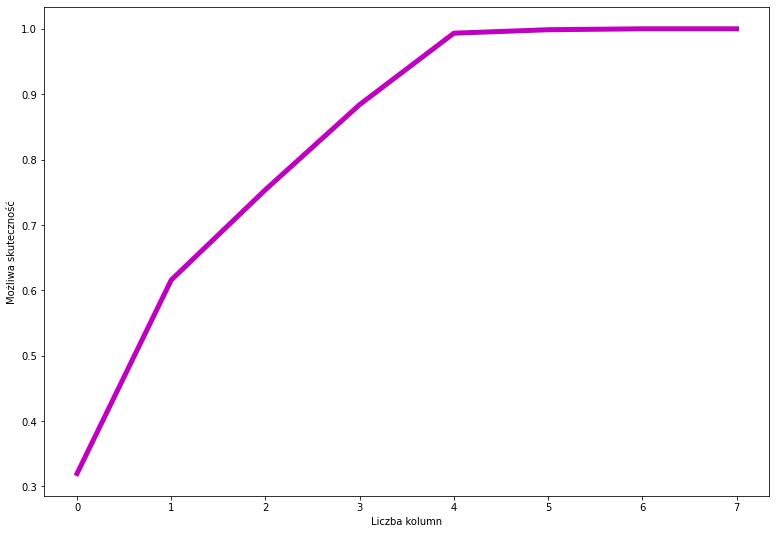

In [160]:
all_columns = [
    'currency',
    'country',
    'state',
    'pledged',
    'backers',
    'goal',
    'main_category',
    'launched',
    'deadline',
]

all_features_columns = [
    'currency',
    'country',
    'pledged',
    'backers',
    'goal',
    'main_category',
    'launched',
    'deadline',
]

labels_columns = ['state']

features = df_train[all_features_columns]
labels = df_train[labels_columns]

pca = PCA().fit(features, labels)
plt.plot(np.cumsum(pca.explained_variance_ratio_), 'm', linewidth=5.0)
plt.xlabel('Liczba kolumn')
plt.ylabel('Możliwa skuteczność')
plt.show()

Na powyższym wykresie można zauważyć, że dla 4 kolumn można osiągnąć maksymalną skuteczność, więc analizowanie większej ilości kolumn nie jest potrzebne. Co więcej, już dla 3 kolumn możliwe jest osiągnięcie ok. 90% skuteczności, co jest bardzo dobrym wynikiem. Analizowanie większej liczby kolumn mogłoby wprowadzić dodatkowy poziom złożoności i niepotrzebną konieczność wykonywania większej liczby obliczeń i analiz.

### Wybór kolumn do dalszej analizy

W celu wybrania kolumn mających największy wpływ na przynależność do klasy można posłużyć się macierzą kowariancji. Na jej podstawie możliwe będzie stworzenie mapy ciepła, która w przejrzysty sposób zobrazuje zależności między poszczególnymi kolumnami.


#### Stworzenie macierzy kowariancji i wygenerowanie heatmapy

0: currency
1: country
2: state
3: pledged
4: backers
5: goal
6: main_category
7: launched
8: deadline


<AxesSubplot:>

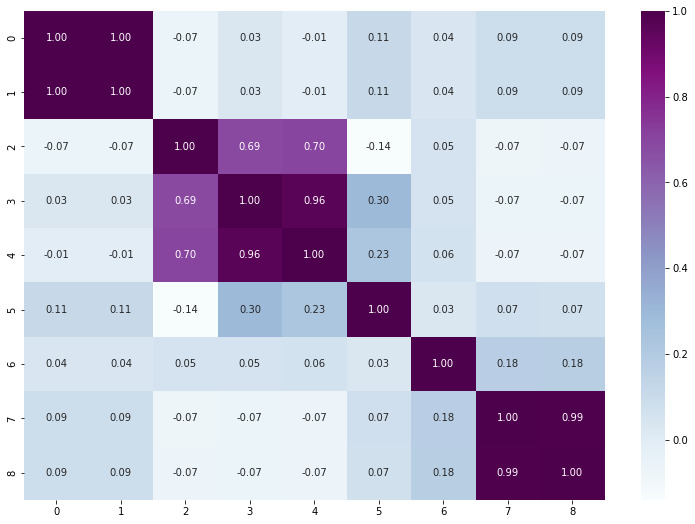

In [161]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_train[all_columns])

covariance_matrix = np.cov(features_scaled.T)

columns_dict = create_label_number_dict(all_columns, True)
for column in all_columns:
    print(f'{columns_dict[column]}: {column}')

fig, ax = plt.subplots(figsize=default_figsize)         # Sample figsize in inches
sns.heatmap(covariance_matrix, annot=True, ax=ax, fmt='0.2f', cmap='BuPu')

Kolumną decyzyjną jest kolumna numer 2 - jest to kolumna mówiąca o tym, czy projekt zakończył się porażką (1) czy sukcesem (2). Z mapy ciepła wynika korelacja następujących 3 kolumn z kolumną decyzyjną:

|  Kolumna 1  |  Kolumna 2  | Kolumna 3 |
|:-----------:|:-----------:|:---------:|
| pledged (3) | backers (4) | goal (5)  |

Na mapie widać inne mocne korelacje, np.:
  - 7 i 8 (_launched_ i _deadline_) - kolumny traktujące o dacie rozpoczęcia i zakończenia zbiórki,
  - 0 i 1 (_currency_ i _country_) - waluta i kraj
  - 3 i 4 (_pledged_ i _backers_) - zebrana kwota i ilość wspierających

Powyższe korelacje, mimo że są wysokie, nie wnoszą nic do analizowanego przykładu.

In [162]:
selected_features = ['pledged', 'backers', 'goal']

#### Uzasadnienie wyboru kolumn

Patrząc na charakterystykę wybranych kolumn, można stwierdzić następujące zależności:
  1. Kolumna **pledged** --- ilość zgromadzonych środków
  2. Kolumna **backers** --- ilość osób wspierających
  3. Kolumna **goal** --- cel zbiórki

Pierwsze 2 kolumny mają oczywisty wpływ na powodzenie projektu, ponieważ im więcej środków zostanie zebranych, tym większa szansa na jego powodzenie. Na ilość środków wpływa z kolei ilość osób wspierających, ponieważ z reguły większa grupa osób jest w stanie zebrać więcej środków niż mniejsza grupa.

W przypadku kolumny **goal** występuje ujemna korelacja z kolumną decyzyjną. Oznacza to tyle, że im mniejsza wartość kolumny **goal** tym większa szansa na powodzenie projektu.

Wobec tego do dalszej analizy będziemy używać tylko wybranych kolumn.

## KNN

KNN (**K**-**N**earest **N**eighbours) - algorytm regresji nieparametrycznej służący do klasyfikacji. Polega na porównaniu wartości cech nieznanego elementu z cechami innych elementów, o których wiemy, do jakiej klasy należą, następnie wybraniu k elementów o najbardziej podobnych cechach (podobieństwo cech można wyznaczyć za pomocą odległości euklidesowej. Im jest ona mniejsza, tym bardziej podobne obiekty) i ostatecznie na sklasyfikowaniu nowego elementu jako należącego do tej klasy, której wystąpień jest więcej w zbiorze k najbliższych sąsiadów.

### Model pojedynczego elementu

In [163]:
class Startup:
    def __init__(self, dataframe_row):
        self.pledged = dataframe_row['pledged']
        self.backers = dataframe_row['backers']
        self.goal = dataframe_row['goal']
        self.state = dataframe_row['state']

    def get_distance_from(self, startup):
        return math.sqrt(
            math.pow(self.pledged - startup.pledged, 2)
            + math.pow(self.backers - startup.backers, 2)
            + math.pow(self.goal - startup.goal, 2)
        )

    def to_string(self):
        return f'pledged: {self.pledged}, backers: {self.backers}, goal: {self.goal}, state: {self.state}'

### Model klasy bazowej

In [164]:
class KnnBase:
    def __init__(self, df):
        self.df = df
        self.count = df['state'].count()
        self.items_objects = self.create_startups_objects(df)

    def create_startups_objects(self, df, clear_state=False):
        count = df['state'].count()
        objects = []
        for i in range(0, count):
            obj = Startup(df.iloc[i])
            if clear_state:
                obj.state = None
            objects.append(obj)
        return objects

## KNN

In [165]:
class Knn(KnnBase):
    def __init__(self, df):
        super().__init__(df)

    def classify(self, unknown, k, print_details=True):
        measured_distances = []
        k_closest = []

        # Calculate distances
        for i in range(0, len(self.items_objects)):
            startup = self.items_objects[i]
            distance = startup.get_distance_from(unknown)
            measured_distances.append({ 'index': i, 'distance': distance, 'class': startup.state })

        # Sort by lower distance
        measured_distances = sorted(measured_distances, key=lambda item: item['distance'])

        # Select the k closest neighbours
        for i in range(0, k):
            k_closest.append(measured_distances[i])

        dominant_class = self.get_dominant_class(k_closest)
        if print_details:
            self.print_selected_closest_neighbours(k_closest)
            print(f'Na podstawie {k} najbliższych sąsiadów, element należy do klasy {dominant_class}')

        return dominant_class

    def get_dominant_class(self, closest):
        classes_dict = {}
        for el in closest:
            class_name = el["class"]
            if class_name not in classes_dict.keys():
                classes_dict[class_name] = 0
            current_class_count_value = int(classes_dict.get(class_name))
            classes_dict[class_name] = current_class_count_value + 1

        return max(classes_dict, key=classes_dict.get)



    def get_all_classes(self, closest):
        classes = []
        for el in closest:
            new_class = el['class']
            if new_class not in classes:
                classes.append(el['class'])
        return classes

    def print_selected_closest_neighbours(self, closest):
        print(f'{len(closest)} najbliższych sąsiadów elementu')
        lp = 1
        for neighbour in closest:
            print(f'  {lp}. Dystans: {neighbour["distance"]} klasa:{neighbour["class"]}')
            lp += 1

### Metryki dla klasyfikacji KNN

Metryki dają informacje w postaci następujących wielkości:
  - **precision** - zdolność klasyfikatora do nieoznaczenia próbki negatywnej jako pozytywnej
  - **recall** - zdolnośc klasyfikatora do znalezienia wszystkich pozytywnych próbek
  - **f1-score** - ważona średnia harmoniczna wartości **precision** i **recall**
  - **support** - ilość próbek

In [238]:
knn_k_means = Knn(df_train)

test_data_size = df_test['state'].count()
classified_correctly = 0

expected_classes = []
predicted_classes = []

for i in range(0, test_data_size):
    new_object = Startup(df_test.iloc[i])
    expected_outcome = new_object.state
    predicted_outcome = knn_k_means.classify(new_object, 3, False)

    expected_classes.append(expected_outcome)
    predicted_classes.append(predicted_outcome)

    if predicted_outcome == expected_outcome:
        classified_correctly += 1

              precision    recall  f1-score   support

  successful       0.98      1.00      0.99        61
      failed       1.00      0.97      0.99        39

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



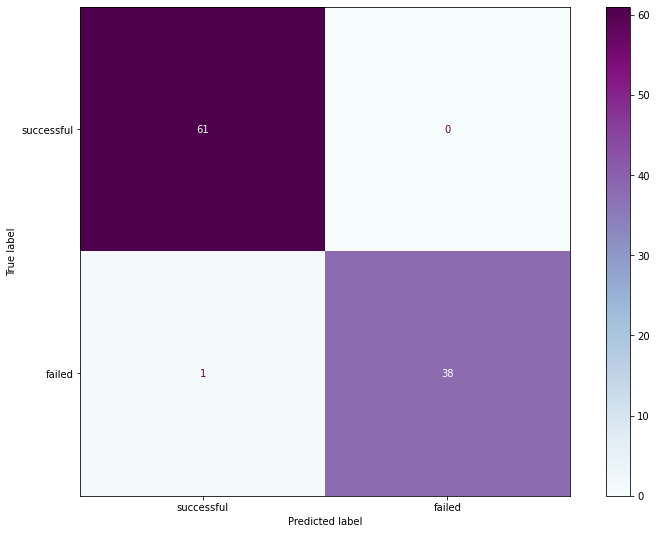

In [239]:
print(classification_report(expected_classes, predicted_classes, target_names=['successful', 'failed']))

disp = ConfusionMatrixDisplay.from_predictions(expected_classes, predicted_classes, display_labels=['successful', 'failed'], cmap=plt.cm.BuPu)
plt.show()

Na powyższych metrykach widać skuteczność algorytmu. Dla 3 najbliższych sąsiadów wynosi ona aż 99%. Przeprowadzono również test dla większej ilości sąsiadów (5 i 7) i dla obu tych wartości skuteczność wynosiła 98%.

Wadą tego algorytmu jest jego koszt, ponieważ dla każdego klasyfikowanego elementu należy obliczyć odległość od wszystkich znanych elementów. Im lepszej dokładności oczekuje się od algorytmu, tym większy zbiór danych uczących powinno się wykorzystać, a to bezpośrednio wpływa na ilość obliczeń, co przy bardzo dużych zbiorach danych może mieć ogromne znaczenie.

## KNN - Centroidy

KNN z centroidami jest rozwinięciem jego podstawowej wersji. Klasyfikacja również polega na obliczeniu odległości (podobieństwa) między obiektem znanym a nieznanym, jednak w tym przypadku różnica jest w porównywanych obiektach. Elementem znanym, jest bowiem centroid. Centroidy są reprezentantami każdej z klas występujących w zbiorze danych, posiadającymi uśrednione wartości innych reprezentantów tychże klas. Innymi słowy, każda klasa ma swojego reprezentanta w postaci centroida. Algorytm wymaga najpierw wytrenowania, które jest dość kosztowne, jednak klasyfikacja sprowadza się już tylko do porównania odległości od kilku centroidów.

**Proces uczenia:**
1. Stwórz k-elementów o losowo wybranych cechach (najlepiej z przedziału wartości cech elementów ze zbioru uczącego) i wybranych klasach.
2. Dla każdego elementu ze zbioru uczącego zmierz odległość do każdego z centroidów i przyporządkuj mu klasę centroida, do którego odległość jest najmniejsza.
3. Oblicz średnie wartości cech dla każdej z klas i przypisz te wartości do centroida o danej klasie. Innymi słowy, ustaw centroid w środku grupy, której odpowiada.
4. Kroki 2-3 powtarzaj tak długo, aż nie dojdzie do sytuacji, kiedy żaden punkt z iteracji na iterację nie zmieni klasy, do której należy (lub inaczej --- kiedy żaden z centroidów nie zmieni swojego położenia)

**Proces klasyfikacji:**
1. Dla każdego nieznanego punktu zmierz odległość od każdego centroida i przyporządkuj mu klasę tego, który jest najbliżej.

In [168]:
class KnnCentroids(KnnBase):
    def __init__(self, df):
        super().__init__(df)
        self.clusters = []
        self.create_startups_objects(df, True)
        self.generate_random_clusters()

    def train(self):
        points_changed = self.match_point_to_clusters()
        counter = 0
        while points_changed and counter < 1000000:
            counter += 1
            self.reposition_clusters()
            points_changed = self.match_point_to_clusters()

    def generate_random_clusters(self):
        clusters =  []
        for i in [0, 1]:
            pledged = rand.uniform(self.df['pledged'].min(), self.df['pledged'].max())
            state = i
            backers = rand.uniform(self.df['backers'].min(), self.df['backers'].max())
            goal = rand.uniform(self.df['goal'].min(), self.df['goal'].max())
            clusters.append(
                Startup(pd.Series({
                    'pledged': pledged,
                    'backers': backers,
                    'goal': goal,
                    'state': state,
                }))
            )

        self.clusters = clusters

    def reposition_clusters(self):
        for cluster in self.clusters:
            pledged_sum = 0
            backers_sum = 0
            pledged_ratio_sum = 0
            count = 0

            for item in self.items_objects:
                if item.state == cluster.state:
                    pledged_sum += item.pledged
                    backers_sum += item.backers
                    pledged_ratio_sum += item.goal
                    count += 1

            if count > 0:
                cluster.pledged = pledged_sum / count
                cluster.backers = backers_sum / count
                cluster.goal = pledged_ratio_sum / count

    def match_point_to_clusters(self):
        changed = 0
        for item in self.items_objects:
            current_state = item.state
            best_distance = None

            for cluster in self.clusters:
                if best_distance is None:
                    best_distance = item.get_distance_from(cluster)
                    new_state = cluster.state
                else:
                    new_distance = item.get_distance_from(cluster)
                    if new_distance < best_distance:
                        best_distance = new_distance
                        new_state = cluster.state

            if current_state != new_state:
                item.state = new_state
                changed += 1
        return changed

    def classify(self, item, print_result=True):
        distance = None
        item_class = None
        for cluster in self.clusters:
            new_distance = item.get_distance_from(cluster)
            new_item_class = cluster.state

            if distance is None:
                distance = new_distance
            if item_class is None:
                item_class = new_item_class
            if distance is not None and distance < new_distance:
                item_class = new_item_class
        if print_result:
            print(f'Element sklasyfikowany jako {item_class}')

        return item_class

### Metryki klasyfikacji KNN dla centroidów

In [244]:
knn_centroids = KnnCentroids(df_train)
knn_centroids.train()

test_data_size = df_test['state'].count()
classified_correctly = 0

expected_classes = []
predicted_classes = []

for i in range(0, test_data_size):
    new_object = Startup(df_test.iloc[i])
    expected_outcome = new_object.state
    predicted_outcome = knn_centroids.classify(new_object, False)

    expected_classes.append(expected_outcome)
    predicted_classes.append(predicted_outcome)

    if predicted_outcome == expected_outcome:
        classified_correctly += 1

              precision    recall  f1-score   support

  successful       0.87      0.77      0.82        61
      failed       0.70      0.82      0.75        39

    accuracy                           0.79       100
   macro avg       0.78      0.80      0.79       100
weighted avg       0.80      0.79      0.79       100



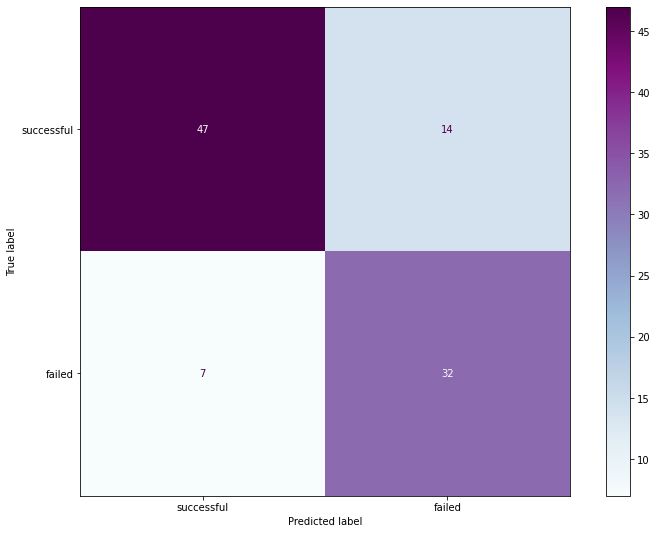

In [245]:
print(classification_report(expected_classes, predicted_classes, target_names=['successful', 'failed']))

disp = ConfusionMatrixDisplay.from_predictions(expected_classes, predicted_classes, display_labels=['successful', 'failed'], cmap=plt.cm.BuPu)
plt.show()

Jak wynika z powyższych metryk, skuteczność algorytmu jest gorsza niż w przypadku klasycznego algorytmu KNN. Niemniej, wynik niemal 80% skuteczności jest dość zadowalający. Warto wspomnieć, że ze względu na to, że w przypadku KNN z centroidami losujemy wartości centroidów, którym przypisujemy klasy, istnieje szansa, że centroidy wylosują się "na odwrót" i będą dokonywały odwrotnej klasyfikacji, dlatego jeżeli wyniki nie są zadowalające, dobrze jest przeprowadzić proces uczenia kilkukrotnie, w celu wykluczenia takiej ewentualności.

## Zbiory rozmyte

In [171]:
def gauss(x, avg, std):
    return np.exp(-(x - avg)**2 / (2 * std**2))

In [172]:
pledged_range = sorted(df_train.query('0.0 < pledged < 1.0')['pledged'])
pledged_1 = sorted(df_train.query('0.0 <= pledged < 0.3')['pledged'])
pledged_2 = sorted(df_train.query('0.3 <= pledged < 0.6')['pledged'])
pledged_3 = sorted(df_train.query('0.6 <= pledged < 1.0')['pledged'])

backers_range = sorted(df_train.query('0.0 < backers < 1.0')['backers'])
backers_1 = sorted(df_train.query('0.0 <= backers < 0.3')['backers'])
backers_2 = sorted(df_train.query('0.3 <= backers < 0.7')['backers'])
backers_3 = sorted(df_train.query('0.7 <= backers < 1.0')['backers'])

goal_range = sorted(df_train.query('0.0 < goal < 1.0')['goal'])
goal_1 = sorted(df_train.query('0.0 <= goal < 0.4')['goal'])
goal_2 = sorted(df_train.query('0.4 <= goal < 0.7')['goal'])
goal_3 = sorted(df_train.query('0.7 <= goal < 1')['goal'])

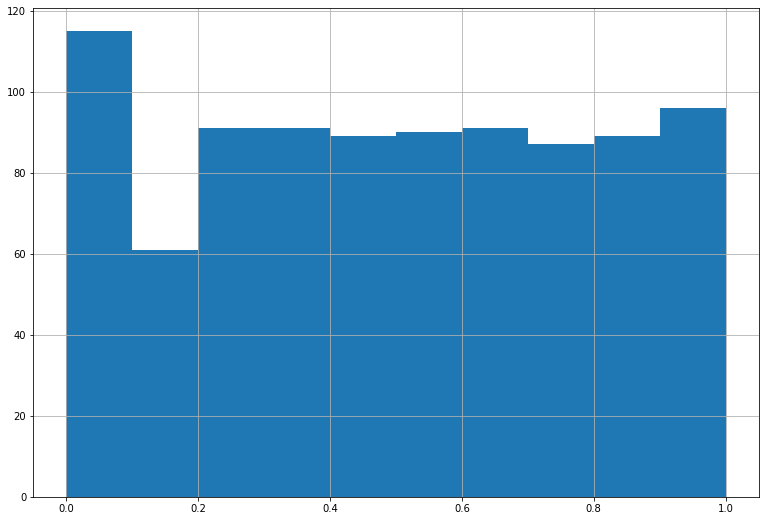

In [173]:
df_train['pledged'].hist()
plt.show()

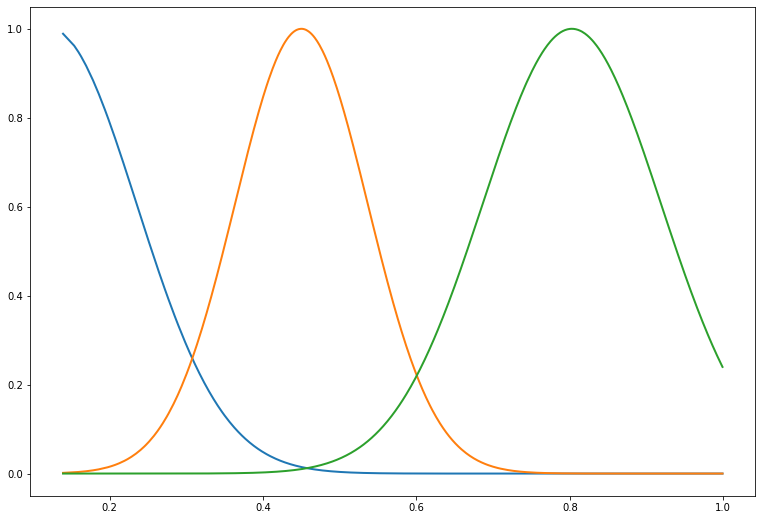

In [174]:
plt.plot(pledged_range, gauss(pledged_range, np.mean(pledged_1), np.std(pledged_1)), linewidth=2)
plt.plot(pledged_range, gauss(pledged_range, np.mean(pledged_2), np.std(pledged_2)), linewidth=2)
plt.plot(pledged_range, gauss(pledged_range, np.mean(pledged_3), np.std(pledged_3)), linewidth=2)
plt.show()

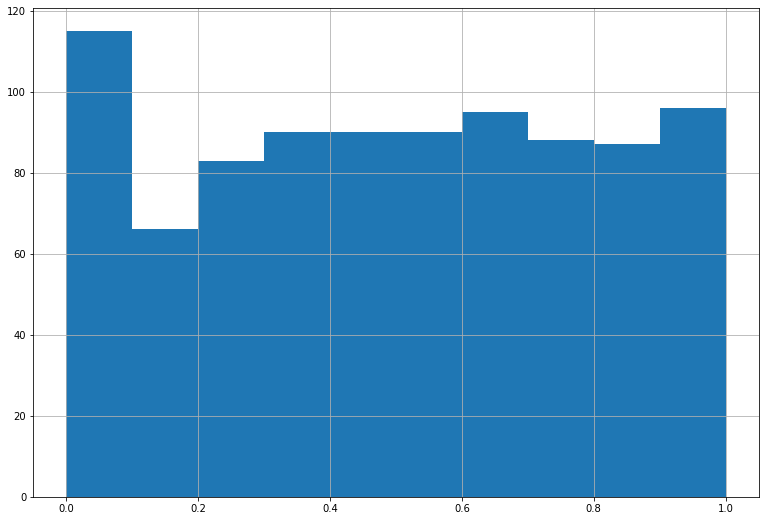

In [175]:
df_train['backers'].hist()
plt.show()

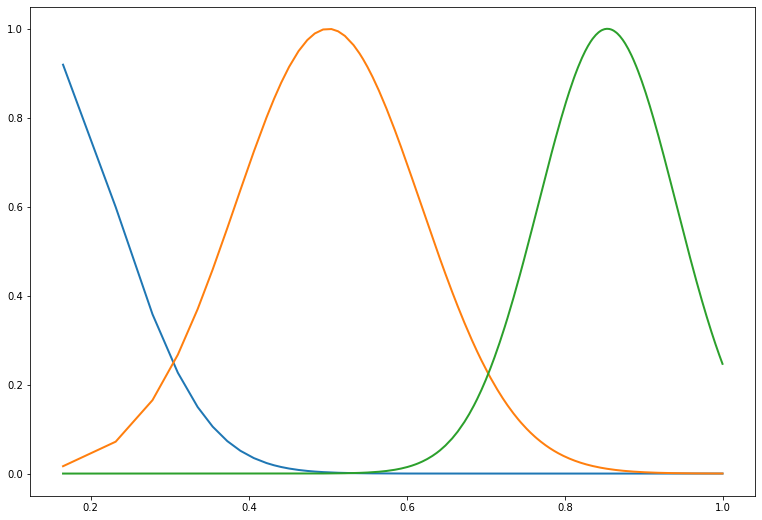

In [176]:
plt.plot(backers_range, gauss(backers_range, np.mean(backers_1), np.std(backers_1)), linewidth=2)
plt.plot(backers_range, gauss(backers_range, np.mean(backers_2), np.std(backers_2)), linewidth=2)
plt.plot(backers_range, gauss(backers_range, np.mean(backers_3), np.std(backers_3)), linewidth=2)
plt.show()

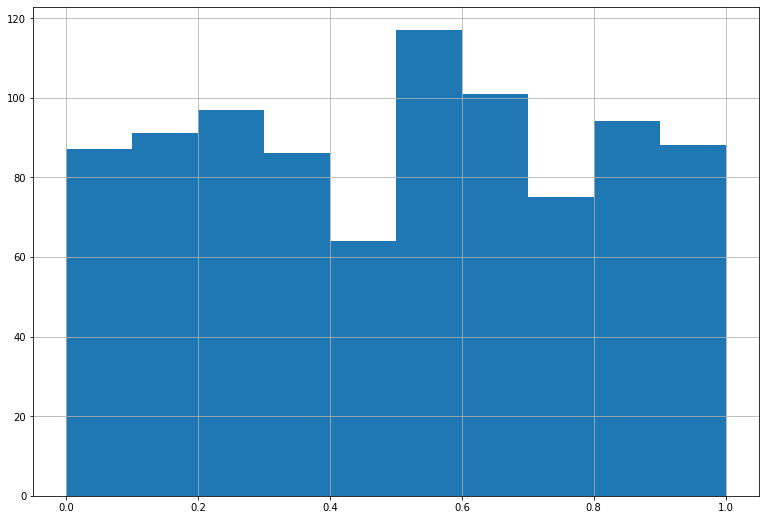

In [177]:
df_train['goal'].hist()
plt.show()

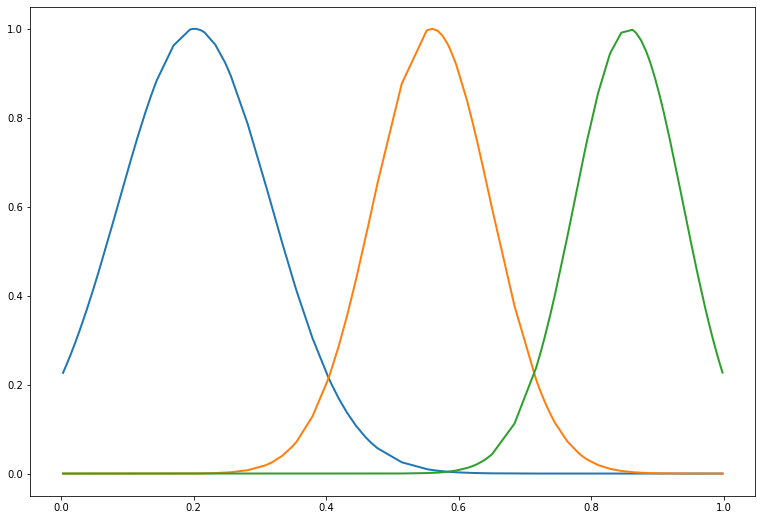

In [178]:
plt.plot(goal_range, gauss(goal_range, np.mean(goal_1), np.std(goal_1)), linewidth=2)
plt.plot(goal_range, gauss(goal_range, np.mean(goal_2), np.std(goal_2)), linewidth=2)
plt.plot(goal_range, gauss(goal_range, np.mean(goal_3), np.std(goal_3)), linewidth=2)
plt.show()

### Funkcje przynależności


In [179]:
class Pledged:
    @staticmethod
    def is_low(value):
        return gauss(value, np.mean(pledged_1), np.std(pledged_1))
    @staticmethod
    def is_medium(value):
        return gauss(value, np.mean(pledged_2), np.std(pledged_2))
    @staticmethod
    def is_high(value):
        return gauss(value, np.mean(pledged_3), np.std(pledged_3))


class Backers:
    @staticmethod
    def is_low(value):
        return gauss(value, np.mean(backers_1), np.std(backers_1))
    @staticmethod
    def is_medium(value):
        return gauss(value, np.mean(backers_2), np.std(backers_2))
    @staticmethod
    def is_high(value):
        return gauss(value, np.mean(backers_3), np.std(backers_3))


class Goal:
    @staticmethod
    def is_low(value):
        return gauss(value, np.mean(goal_1), np.std(goal_1))
    @staticmethod
    def is_medium(value):
        return gauss(value, np.mean(goal_2), np.std(goal_2))
    @staticmethod
    def is_high(value):
        return gauss(value, np.mean(goal_3), np.std(goal_3))

### Takagi Sugeno

### Definicja reguł

In [180]:
def match_rules_previev(pledged, backers, goal, state):
    fuzzy_rules = [
        (Pledged.is_low(pledged) * Backers.is_low(backers) * Goal.is_low(goal)), #1
        (Pledged.is_low(pledged) * Backers.is_low(backers) * Goal.is_medium(goal)), #2
        (Pledged.is_low(pledged) * Backers.is_low(backers) * Goal.is_high(goal)), #3
        (Pledged.is_low(pledged) * Backers.is_medium(backers) * Goal.is_low(goal)), #4
        (Pledged.is_low(pledged) * Backers.is_medium(backers) * Goal.is_medium(goal)), #5
        (Pledged.is_low(pledged) * Backers.is_medium(backers) * Goal.is_high(goal)), #6
        (Pledged.is_low(pledged) * Backers.is_high(backers) * Goal.is_low(goal)), #7
        (Pledged.is_low(pledged) * Backers.is_high(backers) * Goal.is_medium(goal)), #8
        (Pledged.is_low(pledged) * Backers.is_high(backers) * Goal.is_high(goal)), #9

        (Pledged.is_medium(pledged) * Backers.is_low(backers) * Goal.is_low(goal)), #10
        (Pledged.is_medium(pledged) * Backers.is_low(backers) * Goal.is_medium(goal)), #11
        (Pledged.is_medium(pledged) * Backers.is_low(backers) * Goal.is_high(goal)), #12
        (Pledged.is_medium(pledged) * Backers.is_medium(backers) * Goal.is_low(goal)), #13
        (Pledged.is_medium(pledged) * Backers.is_medium(backers) * Goal.is_medium(goal)), #14
        (Pledged.is_medium(pledged) * Backers.is_medium(backers) * Goal.is_high(goal)), #15
        (Pledged.is_medium(pledged) * Backers.is_high(backers) * Goal.is_low(goal)), #16
        (Pledged.is_medium(pledged) * Backers.is_high(backers) * Goal.is_medium(goal)), #17
        (Pledged.is_medium(pledged) * Backers.is_high(backers) * Goal.is_high(goal)), #18

        (Pledged.is_high(pledged) * Backers.is_low(backers) * Goal.is_low(goal)), #19
        (Pledged.is_high(pledged) * Backers.is_low(backers) * Goal.is_medium(goal)), #20
        (Pledged.is_high(pledged) * Backers.is_low(backers) * Goal.is_high(goal)), #21
        (Pledged.is_high(pledged) * Backers.is_medium(backers) * Goal.is_low(goal)), #22
        (Pledged.is_high(pledged) * Backers.is_medium(backers) * Goal.is_medium(goal)), #23
        (Pledged.is_high(pledged) * Backers.is_medium(backers) * Goal.is_high(goal)), #24
        (Pledged.is_high(pledged) * Backers.is_high(backers) * Goal.is_low(goal)), #25
        (Pledged.is_high(pledged) * Backers.is_high(backers) * Goal.is_medium(goal)), #26
        (Pledged.is_high(pledged) * Backers.is_high(backers) * Goal.is_high(goal)), #27
    ]

    return {
        'expected_output': state,
        'max_index': fuzzy_rules.index(max(fuzzy_rules)) + 1,
    }

In [181]:
from collections import Counter

failed = []
successful = []

for index in df_train.index:
    row = df_train.loc[index]
    state = row['state']

    if state == 0:
        failed.append(match_rules_previev(row['pledged'], row['backers'], row['goal'], row['state']))
    else:
        successful.append(match_rules_previev(row['pledged'], row['backers'], row['goal'], row['state']))

# failed.sort(key=lambda item: item['rule_value'])
# successful.sort(key=lambda item: item['rule_value'])

failed_max_rules = list(map(lambda x: x['max_index'], failed))
successful_max_rules = list(map(lambda x: x['max_index'], successful))

In [182]:
print('Reguły dla niepowodzenia startupu')
print(Counter(failed_max_rules))

print('\nReguły dla powodzenia startupu')
print(Counter(successful_max_rules))

Reguły dla niepowodzenia startupu
Counter({1: 107, 2: 81, 3: 58, 13: 58, 14: 52, 15: 46, 27: 29, 24: 22, 23: 13, 4: 13, 12: 6, 26: 6, 5: 6, 10: 6, 18: 5, 6: 4, 17: 3, 11: 3, 22: 1})

Reguły dla powodzenia startupu
Counter({26: 92, 27: 81, 13: 75, 25: 49, 22: 40, 23: 24, 24: 6, 16: 6, 4: 5, 10: 2, 1: 1})


W powyższej komórce przedstawiono reguły przyporządkowane klasom, oraz jak często były przyporządkowywane, czyli:

Klasa 0: reguła pierwsza wystąpiła 98 razy, druga 87 razy, itd.
Klasa 0: reguła 26 wystąpiła 91 razy, 13 74 razy, itd.

Pozwoli to wybrać ostateczne reguły. Można zauważyć, że reguła 13 pojawiła się dość wysoko zarówno w klasie określającej powodzenie jak i niepowodzenie startupu. Wobec tego, należy wyeliminować tego typu wystąpienia.

### Reguły wybrane

In [183]:
def match_rules(pledged, backers, goal):
    # Wybrane reguły rozmyte
    fuzzy_rules = [
        # Reguły dla klasy 0 (niepowodzenie)
        (Pledged.is_low(pledged) * Backers.is_low(backers) * Goal.is_low(goal)), #1
        (Pledged.is_low(pledged) * Backers.is_low(backers) * Goal.is_medium(goal)), #2
        (Pledged.is_low(pledged) * Backers.is_low(backers) * Goal.is_high(goal)), #3
        (Pledged.is_medium(pledged) * Backers.is_medium(backers) * Goal.is_medium(goal)), #14
        (Pledged.is_medium(pledged) * Backers.is_medium(backers) * Goal.is_high(goal)), #15

        # Reguły dla klasy 0 (powodzenie)
        (Pledged.is_high(pledged) * Backers.is_high(backers) * Goal.is_low(goal)), #25
        (Pledged.is_high(pledged) * Backers.is_high(backers) * Goal.is_medium(goal)), #26
        (Pledged.is_high(pledged) * Backers.is_high(backers) * Goal.is_high(goal)), #27
    ]

    decisions = [0, 0, 0, 0, 0, 1, 1, 1]

    failed = []
    successful = []

    for i in range(len(decisions)):
        if decisions[i] == 0:
            failed.append(fuzzy_rules[i])
        else:
          successful.append(fuzzy_rules[i])

    return {
      "max_failed": max(failed),
      "index_failed": fuzzy_rules.index(max(failed)),
      "max_successful": max(successful),
      "index_successful": fuzzy_rules.index(max(successful)),
    }

In [191]:
result = []

for index in df_test.index:
    row = df_test.loc[index]
    value = match_rules(row['pledged'], row['backers'], row['goal'])
    result.append({
        'rule_data': value,
        'decision': row['state']
    })

In [185]:
list_0 = []
list_1 = []

for el in result:
  if(el["decision"] == 0):
    list_0.append(el["rule_data"]["index_failed"])
  else:
    list_1.append(el["rule_data"]["index_successful"])

print(Counter(list_0))
print(Counter(list_1))

Counter({0: 152, 3: 110, 4: 106, 1: 87, 2: 64})
Counter({5: 178, 6: 116, 7: 87})


### Wnioskowanie Takagi Sugeno

In [220]:
def takagi_sugeno(data):
  coefficient_array = [0.3, 1]
  denominator = 0
  nominator = 0

  for i in range(len(data)):
    nominator = nominator + (data[i] * coefficient_array[i])
    denominator = denominator + coefficient_array[i]

  return nominator / denominator

### Wyznaczanie tresholdu

**Treshold** (ang. _próg_) to wartość będąca buforem pomiędzy poszczególnymi przedziałami rozmytymi (mało, średnio, dużo), po której przekroczeniu wartość traktowana jest jako należąca już do innego przedziału. Jego wyznaczenie pomoże w podejmowaniu decyzji.

In [219]:
tab_failed = []
tab_successful = []

for i in range(0, len(result)):
  if result[i]['decision'] == 0:
    tab_failed.append(takagi_sugeno([result[i]['rule_data']['max_failed'], result[i]['rule_data']['max_successful']]))
  else:
    tab_successful.append(takagi_sugeno([result[i]['rule_data']['max_failed'], result[i]['rule_data']['max_successful']]))

print(f'0: {np.mean(tab_failed)}\n'
      f'1: {np.mean(tab_successful)}\n\n'
      f'średnia: {(np.mean(tab_failed) + np.mean(tab_successful)) / 2}')

0: 0.0639288723130711
1: 0.19249207907292912

średnia: 0.1282104756930001


W powyższym wyniku widać, że średnia wartość tresholdu wynosi odpowiednio 0.06 dla klasy 0 oraz 0.19 dla klasy 1. Ich średnia powinna być złotym środkiem w wyborze uniwersalnej wartości.

Jak można zauważyć w poniższym fragmencie kodu, używany treshold jest widocznie niższy od sugerowanego. Wynika to z przeprowadzonych testów, które potwierdziły 2 rzeczy:

1. Im bardziej zbliżamy się do wartości tresholdu odpowiadającego danej klasie, tym bardziej predykcja danej klasy jest dokładna przy jednoczesnym spadku dokładności predykcji klasy przeciwnej.
2.

              precision    recall  f1-score   support

  successful       0.64      0.85      0.73        61
      failed       0.53      0.26      0.34        39

    accuracy                           0.62       100
   macro avg       0.58      0.55      0.54       100
weighted avg       0.60      0.62      0.58       100



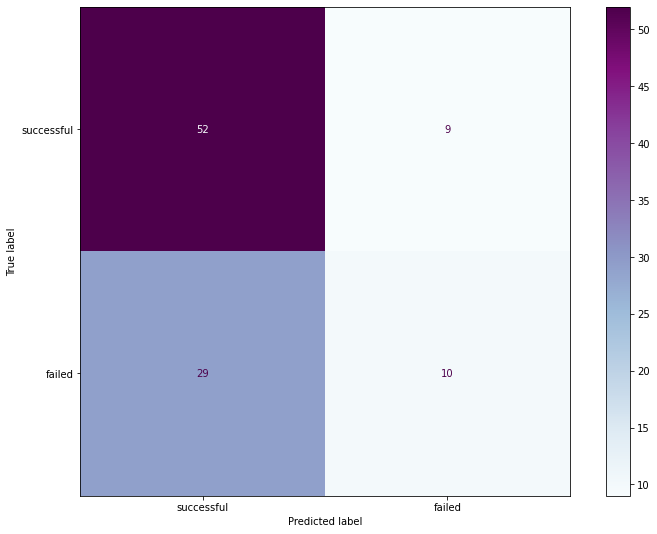

In [228]:
predicted_classes = []
treshold = 0.01

for index in df_test.index:
    row = df_test.loc[index]
    element = match_rules(row['pledged'], row['backers'], row['goal'])

    if takagi_sugeno([element['max_failed'], element['max_successful']]) > treshold:
        predicted_classes.append(0)
    else:
        predicted_classes.append(1)

print(classification_report(expected_classes, predicted_classes, target_names=['successful', 'failed']))

disp = ConfusionMatrixDisplay.from_predictions(expected_classes, predicted_classes, display_labels=['successful', 'failed'], cmap=plt.cm.BuPu)
plt.show()